In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Debug"
sys.path.append(atlas_path)


from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy.ast import *

In [11]:
exchange_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/src/exchangeVBT"
strategy_id = "test_strategy"
exchange_id = "test_exchange"
portfolio_id = "test_portfolio"

hydra = Hydra()
intial_cash = 100.0
exchange = hydra.addExchange(exchange_id, exchange_path, "%Y-%m-%d %H:%M:%S")
portfolio = hydra.addPortfolio(portfolio_id, exchange, intial_cash)
hydra.build()

In [19]:
hydra.reset()
multiplier = 3
st = time.perf_counter_ns()
close = AssetReadNode.make("Close", 0, exchange)
previous_close = AssetReadNode.make("Close", -1, exchange)

atr_node = ATRNode.make(
    exchange,
    "High",
    "Low",
    14
) 
median_node = AssetMedianNode.make(
    exchange,
    "High",
    "Low",
)

# ===== Lower Band =====
lower_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.SUBTRACT
)
lower_left_cond = AssetIfNode(
    lower_band,
    AssetCompType.GREATER,
    DummyNode(exchange)
)
lower_right_cond = AssetIfNode(
    previous_close,
    AssetCompType.LESS, 
    DummyNode(exchange)
)
final_lower_band = AssetCompNode(
    lower_left_cond,
    LogicalType.OR,
    lower_right_cond,
    lower_band,
    DummyNode(exchange)
)
lagged_final_lower_band = final_lower_band.lag(1)
lower_left_cond.swapRightEval(lagged_final_lower_band)
lower_right_cond.swapRightEval(lagged_final_lower_band)
final_lower_band.swapFalseEval(lagged_final_lower_band)
# ======================

# ===== Upper Band =====
upper_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.ADD
)
upper_left_cond = AssetIfNode(
    upper_band,
    AssetCompType.LESS,
    DummyNode(exchange)
)
upper_right_cond = AssetIfNode(
    previous_close,
    AssetCompType.GREATER, 
    DummyNode(exchange)
)
final_upper_band = AssetCompNode(
    upper_left_cond,
    LogicalType.OR,
    upper_right_cond,
    upper_band,
    DummyNode(exchange)
)
lagged_final_upper_band = final_upper_band.lag(1)
upper_left_cond.swapRightEval(lagged_final_upper_band)
upper_right_cond.swapRightEval(lagged_final_upper_band)
final_upper_band.swapFalseEval(lagged_final_upper_band)
# ======================


exchange.enableNodeCache("final_lower_band",final_lower_band)
exchange.enableNodeCache("final_upper_band",final_upper_band)
et = time.perf_counter_ns()
print(f"Time to build: {(et-st)/1e6}ms")

Time to build: 99.7195ms


In [20]:
final_lower_band.cache(), final_upper_band.cache()

(array([[    0.        ,     0.        ,     0.        , ...,
         40304.66724192, 40304.66724192, 40304.66724192]]),
 array([[    0.        ,     0.        ,     0.        , ...,
         45400.69328861, 45400.69328861, 45400.69328861]]))

In [24]:
path = os.path.join(exchange_path,"BTC-USD.csv")  
df = pd.read_csv(path)
df["final_upper_band"] = final_upper_band.cache()[0]
df["final_lower_band"] = final_lower_band.cache()[0]

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,final_upper_band,final_lower_band
Date,,,,,,,,,
2018-01-01 00:00:00+00:00,14112.200195,14112.200195,13154.700195,13657.200195,10291200000,0.0,0.0,0.000000,0.000000
2018-01-02 00:00:00+00:00,13625.000000,15444.599609,13163.599609,14982.099609,16846600192,0.0,0.0,0.000000,0.000000
2018-01-03 00:00:00+00:00,14978.200195,15572.799805,14844.500000,15201.000000,16871900160,0.0,0.0,0.000000,0.000000
2018-01-04 00:00:00+00:00,15270.700195,15739.700195,14522.200195,15599.200195,21783199744,0.0,0.0,0.000000,0.000000
2018-01-05 00:00:00+00:00,15477.200195,17705.199219,15202.799805,17429.500000,23840899072,0.0,0.0,0.000000,0.000000
2018-01-06 00:00:00+00:00,17462.099609,17712.400391,16764.599609,17527.000000,18314600448,0.0,0.0,0.000000,0.000000
2018-01-07 00:00:00+00:00,17527.300781,17579.599609,16087.700195,16477.599609,15866000384,0.0,0.0,0.000000,0.000000
2018-01-08 00:00:00+00:00,16476.199219,16537.900391,14208.200195,15170.099609,18413899776,0.0,0.0,0.000000,0.000000
2018-01-09 00:00:00+00:00,15123.700195,15497.500000,14424.000000,14595.400391,16659999744,0.0,0.0,0.000000,0.000000


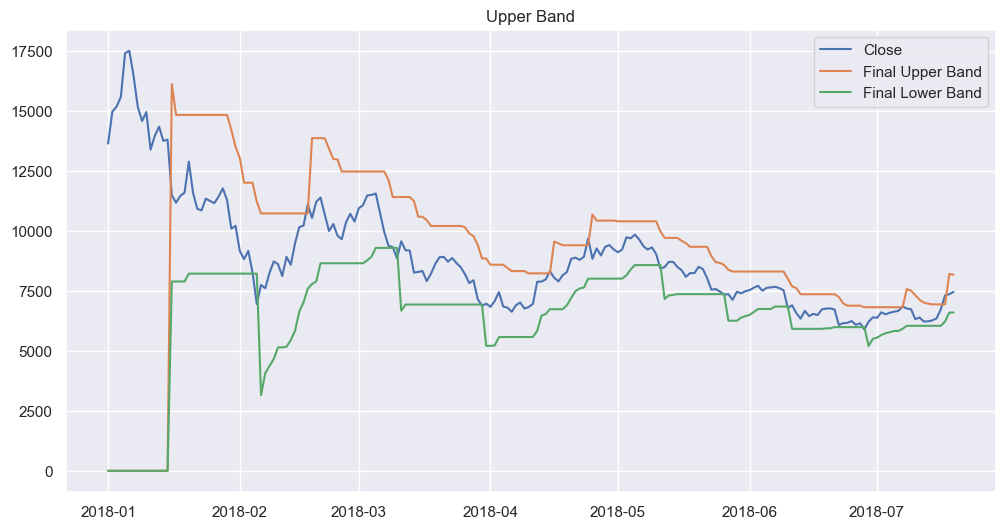

In [22]:
n = 200
df_sub = df.iloc[:n]
plt.figure(figsize=(12,6))
plt.plot(df_sub["Close"], label="Close")
plt.plot(df_sub["final_upper_band"], label="Final Upper Band")
plt.plot(df_sub["final_lower_band"], label="Final Lower Band")
plt.title("Upper Band")
plt.legend()
plt.show()